<a href="https://colab.research.google.com/github/HamoyeHQ/stage-f-10-police-shootings/blob/master/police_shootingTS_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Police Shooting Time Series**

In [29]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [30]:
!ls "/content/gdrive/My Drive"

'Colab Notebooks'		   kaggle		       shootings.csv
 household_power_consumption.zip  'my kaggle screenshot.jpg'


In [31]:
import datetime
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
import plotly 
!pip install --upgrade pip chart_studio
import chart_studio.plotly as py
import plotly.tools as tls
from plotly.offline import iplot
import plotly.tools as tls 
from plotly.graph_objs import * 


Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (20.2.4)
Requirement already up-to-date: chart_studio in /usr/local/lib/python3.6/dist-packages (1.1.0)


In [32]:
df = pd.read_csv('/content/gdrive/My Drive/shootings.csv')
df.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,arms_category
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,Asian,Shelton,WA,True,attack,Not fleeing,False,Guns
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,White,Aloha,OR,False,attack,Not fleeing,False,Guns
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,Hispanic,Wichita,KS,False,other,Not fleeing,False,Unarmed
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,White,San Francisco,CA,True,attack,Not fleeing,False,Other unusual objects
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,Hispanic,Evans,CO,False,attack,Not fleeing,False,Piercing objects


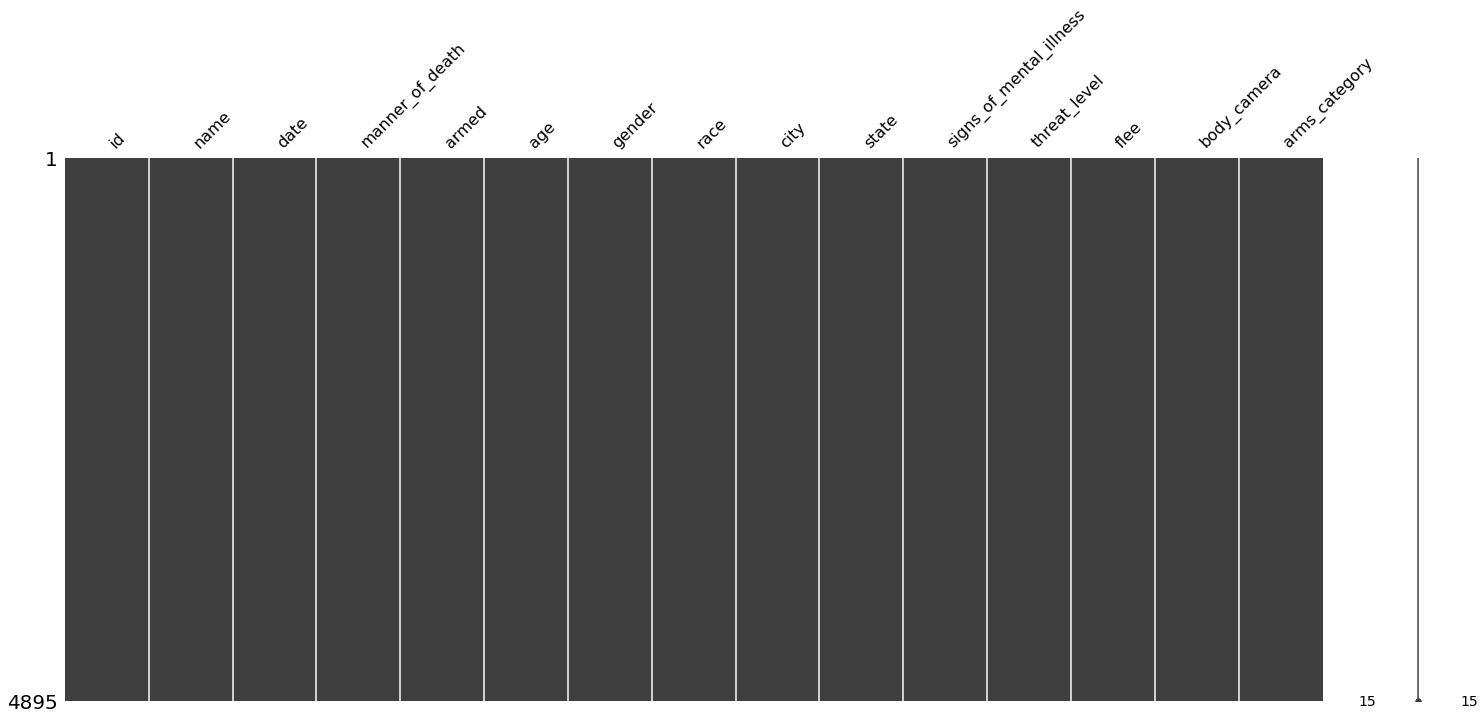

In [33]:
import missingno as msno
msno.matrix(df)

No missing value found

In [34]:
for col in df.columns:
    print(col, str(round(100* df[col].isnull().sum() / len(df), 2)) + '%')

id 0.0%
name 0.0%
date 0.0%
manner_of_death 0.0%
armed 0.0%
age 0.0%
gender 0.0%
race 0.0%
city 0.0%
state 0.0%
signs_of_mental_illness 0.0%
threat_level 0.0%
flee 0.0%
body_camera 0.0%
arms_category 0.0%


In [35]:
data = df['manner_of_death'].value_counts().reset_index()
data.columns = ['manner_of_death', 'count']

fig = px.pie(
    data, 
    values='count', 
    names='manner_of_death', 
    title='Manner of death', 
    width=500, 
    height=500
)

fig.show()


In [36]:
data = df['armed'].value_counts().reset_index()
data.columns = ['armed', 'count']
data = data.sort_values('count')

fig = px.bar(
    data.tail(25), 
    x='count', 
    y='armed', 
    orientation='h', 
    title='Weapon', 
    width=800, 
    height=800
)

fig.show()

In [37]:
fig = px.histogram(
    df, 
    "age", 
    nbins=80, 
    title ='Age distribution', 
    width=800,
    height=500
)

fig.show()

In [38]:
fig = go.Figure(
    data=go.Violin(
        y=df['age'], 
        x0='Age'
    )
)

fig.show()

In [39]:
data = df['gender'].value_counts().reset_index()
data.columns = ['gender', 'count']

fig = px.pie(
    data, 
    values='count', 
    names='gender',  
    title='Gender distribution', 
    width=500, 
    height=500
)

fig.show()

In [40]:
data = df['race'].value_counts().reset_index()
data.columns = ['race', 'count']
data = data.sort_values('count')

fig = px.bar(
    data, 
    x='count', 
    y='race', 
    orientation='h', 
    title='Race distribution', 
    width=600,
    height=600
)

fig.show()

In [41]:
city = df.groupby('city')['name'].count().reset_index().sort_values('name', ascending=True).tail(50)

fig = px.bar(
    city, 
    x="name", 
    y="city", 
    orientation='h',
    title="Top 50 cities by deaths", 
    width=800, 
    height=900
)

fig.show()


**Lets extract some standard features from date and check them**

In [42]:
df["date"] = pd.to_datetime(df["date"])
df["weekday"] = df["date"].dt.weekday
df['month'] = df['date'].dt.month
df['month_day'] = df['date'].dt.day
df['year'] = df['date'].dt.year

In [43]:
data = df.groupby(['weekday'])['name'].count().reset_index()
data.columns = ['weekday', 'count']

fig = px.bar(
    data, 
    x='weekday', 
    y='count',
    orientation='v', 
    title='Day of week', 
    width=600
)

fig.show()


In [44]:
data = df.groupby(['month'])['name'].count().reset_index()
data.columns = ['month', 'count']

fig = px.bar(
    data, 
    x='month', 
    y='count', 
    orientation='v', 
    title='Month of year', 
    width=800
)

fig.show()

In [45]:
data = df.groupby(['month_day'])['name'].count().reset_index()
data.columns = ['month_day', 'count']

fig = px.bar(
    data, 
    x='month_day', 
    y='count', 
    orientation='v', 
    title='Day of month', 
    width=800
)

fig.show()

In [46]:
data = df.groupby(['year'])['name'].count().reset_index()
data.columns = ['year', 'count']

fig = px.bar(
    data, 
    x='year', 
    y='count',
    orientation='v', 
    title='Year', 
    width=600
)

fig.show()

In [47]:
df['month_year'] = pd.to_datetime(df['date']).dt.to_period('M')
df.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,arms_category,weekday,month,month_day,year,month_year
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,Asian,Shelton,WA,True,attack,Not fleeing,False,Guns,4,1,2,2015,2015-01
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,White,Aloha,OR,False,attack,Not fleeing,False,Guns,4,1,2,2015,2015-01
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,Hispanic,Wichita,KS,False,other,Not fleeing,False,Unarmed,5,1,3,2015,2015-01
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,White,San Francisco,CA,True,attack,Not fleeing,False,Other unusual objects,6,1,4,2015,2015-01
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,Hispanic,Evans,CO,False,attack,Not fleeing,False,Piercing objects,6,1,4,2015,2015-01


In [48]:
data = df.groupby(['month_year'])['name'].count().reset_index()
data.columns = ['month_year', 'count']
data['month_year'] = data['month_year'].astype(str)

fig = px.bar(
    data, 
    x='month_year', 
    y='count', 
    orientation='v', 
    title='Deaths by months', 
    width=800
)

fig.show()


In [49]:
data = df.groupby(['flee'])['name'].count().reset_index()
data.columns = ['flee', 'count']
fig = px.bar(
    data, 
    x='flee', 
    y='count', 
    orientation='v', 
    title='Flee distribution', 
    width=600
)
fig.show()

**We will use simple ARIMA model for forecasting**

In [50]:
data = df.groupby(['month_year'])['name'].count().reset_index()
data.columns = ['month_year', 'count']
data['month_year'] = data['month_year'].astype(str)
data = data.head(65)

fig = px.line(
    data, 
    x="month_year", 
    y="count", 
    title='Deaths month by month'
)

fig.show()

In [51]:
model = ARIMA(data['count'], order=(3,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.count   No. Observations:                   64
Model:                 ARIMA(3, 1, 1)   Log Likelihood                -248.364
Method:                       css-mle   S.D. of innovations             11.309
Date:                Fri, 20 Nov 2020   AIC                            508.728
Time:                        15:58:03   BIC                            521.681
Sample:                             1   HQIC                           513.830
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.1943      0.063     -3.080      0.003      -0.318      -0.071
ar.L1.D.count     0.0427      0.125      0.341      0.734      -0.203       0.288
ar.L2.D.count    -0.1492      0.123     

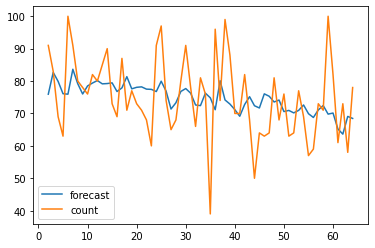

In [52]:
model_fit.plot_predict(dynamic=False)
plt.show()

In [53]:
preds, _, _ = model_fit.forecast(19, alpha=0.05)
preds = preds.tolist()
preds = [int(item) for item in preds]
months = ['2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', 
          '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12']

new_df = pd.DataFrame()
new_df['month_year'] = months
new_df['count'] = preds
data = pd.concat([data, new_df])

In [54]:
fig = px.line(
    data, 
    x="month_year", 
    y="count", 
    title='Deaths month by month with predictions'
)

fig.show()
